In [1]:
import os
import re
import string
from tqdm import tqdm_notebook as tqdm

import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix

from preprocess import clean_text
from utils import load_data, create_tokenizer, load_tokenizer

Using TensorFlow backend.


In [2]:
data_dir = "data/youtube_comments"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

train_texts, train_labels = load_data(train_dir)
test_texts, test_labels = load_data(test_dir)

pos: 100%|██████████| 681/681 [00:00<00:00, 1364.10it/s]


In [3]:
# Tokenizer params
vocab_size = 2000
embed_size = 300

# Cut comment after maxlen words
maxlen = 20

n_epochs = 500

In [4]:
tokenizer = load_tokenizer("tokenizer.pickle")
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(train_sequences, maxlen)
y_train = np.asarray(train_labels)
X_test = pad_sequences(test_sequences, maxlen)
y_test = np.asarray(test_labels)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

tokenizer.word_index

X_train shape:  (4605, 20)
y_train shape:  (4605,)
X_test shape:  (1151, 20)
y_test shape:  (1151,)


{'hay': 1,
 'nghe': 2,
 'quá': 3,
 'này': 4,
 'bài': 5,
 'là': 6,
 'hát': 7,
 'như': 8,
 'anh': 9,
 'có': 10,
 'của': 11,
 'mà': 12,
 'em': 13,
 'nhạc': 14,
 'mình': 15,
 'cái': 16,
 'rồi': 17,
 'không': 18,
 'bài_hát': 19,
 'thì': 20,
 'ko': 21,
 'và': 22,
 'rất': 23,
 'cũng': 24,
 'lại': 25,
 'chị': 26,
 'thấy': 27,
 'gì': 28,
 'đi': 29,
 'mv': 30,
 'thích': 31,
 'cho': 32,
 'đã': 33,
 'con': 34,
 'còn': 35,
 'ra': 36,
 'ơi': 37,
 'người': 38,
 'hơn': 39,
 'những': 40,
 'nhưng': 41,
 'nhiều': 42,
 'luôn': 43,
 'vẫn': 44,
 'yêu': 45,
 'thật': 46,
 'ai': 47,
 'một': 48,
 'được': 49,
 'đến': 50,
 'lắm': 51,
 'bạn': 52,
 'giọng': 53,
 'nào': 54,
 'mới': 55,
 'với': 56,
 'lần': 57,
 'sao': 58,
 'từ': 59,
 'tôi': 60,
 'lời': 61,
 'nó': 62,
 'làm': 63,
 'đây': 64,
 'trong': 65,
 'đó': 66,
 'xem': 67,
 'chỉ': 68,
 'vậy': 69,
 'đẹp': 70,
 'vào': 71,
 'biết': 72,
 'mấy': 73,
 'cứ': 74,
 'cả': 75,
 'để': 76,
 'nhìn': 77,
 'k': 78,
 'nói': 79,
 'phải': 80,
 'qua': 81,
 'v': 82,
 'khi': 83,
 'thằ

In [20]:
w2v_model = load_model("word2vec_model.h5")
w2v_weights = w2v_model.get_layer("embedding").get_weights()


model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=maxlen, name="embedding"))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

embedding_layer = model.get_layer("embedding")
embedding_layer.set_weights(w2v_weights)
embedding_layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           600000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               600100    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 1,200,201
Trainable params: 600,201
Non-trainable params: 600,000
_________________________________________________________________


In [21]:
callbacks = [EarlyStopping(monitor='val_acc', patience=50, verbose=2, restore_best_weights=True)]

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [22]:
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=128,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test))

Train on 4605 samples, validate on 1151 samples
Epoch 1/500
4605/4605 [==============================] - 1s 241us/step - loss: 0.5800 - acc: 0.7553 - val_loss: 0.4407 - val_acc: 0.8149
Epoch 2/500
4605/4605 [==============================] - 0s 82us/step - loss: 0.2011 - acc: 0.9229 - val_loss: 0.4997 - val_acc: 0.8193
Epoch 3/500
4605/4605 [==============================] - 0s 82us/step - loss: 0.1224 - acc: 0.9605 - val_loss: 0.5558 - val_acc: 0.8271
Epoch 4/500
4605/4605 [==============================] - 0s 82us/step - loss: 0.0839 - acc: 0.9739 - val_loss: 0.7016 - val_acc: 0.8210
Epoch 5/500
4605/4605 [==============================] - 0s 84us/step - loss: 0.0622 - acc: 0.9833 - val_loss: 0.7587 - val_acc: 0.8071
Epoch 6/500
4605/4605 [==============================] - 0s 107us/step - loss: 0.0517 - acc: 0.9839 - val_loss: 0.7910 - val_acc: 0.8106
Epoch 7/500
4605/4605 [==============================] - 0s 99us/step - loss: 0.0402 - acc: 0.9898 - val_loss: 0.8674 - val_acc: 0.807

In [26]:
model.save("model.h5")

In [28]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[397  73]
 [ 60 621]]


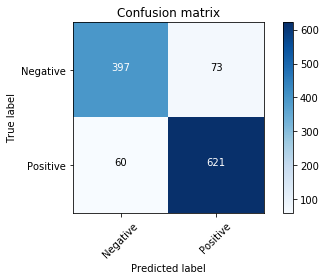

In [32]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict_classes(X_test).flatten()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      normalize=False,
                      classes=["Negative", "Positive"], 
                      title="Confusion matrix")

In [27]:
from sklearn.metrics import precision_recall_fscore_support
y_pred = model.predict_classes(X_test).flatten()
precision_recall_fscore_support(y_test, y_pred, average="weighted")


(0.8841534767929613, 0.8844483058210252, 0.8841843171706778, None)

In [28]:
print(model.evaluate(X_test, y_test))

1151/1151 [==============================] - 1s 628us/step
[0.48567658129409536, 0.8844483059245953]


In [26]:
model = load_model("model.h5")

In [42]:
import numpy as np
np.intersect1d(np.where(y_test != y_pred), np.where(y_test == 0))

TypeError: intersect1d() missing 1 required positional argument: 'ar2'

In [50]:
test_text_arr = np.asarray(test_texts)
test_text_arr[np.intersect1d(np.where(y_test != y_pred), np.where(y_test == 1))]

array(['Mv vui_nhộn   nhảy đẹp   hình_ảnh đầu_tư   có gì mà phải không thích nhỉ   xem thì sướng cái mắt chứ chết thằng nào đâu ',
       'Nghe xong bài này có cảm_giác mong thời_gian trôi mau để gặp người mik muốn gặp ',
       'Giong chi Linh nghe that tham   mot_su ket hop hoan hao ',
       'Nghe mộng mị Mang lại cho tôi cảm_giác như lúc tôi đọc thơ của Hàn_Mặc_Tử   mơ_mơ mà thật thật   như làn sương khói giăng mắc khắp không_gian mà_lại có chút điên_điên      ',
       'cái này thấy hay hơn MV ', 'Wow hấp_dẫn nhaaa ',
       'Giống Tùng thật   v ', 'nhạc hay mà xem xong không làm gì ',
       'Bài hát sôi_động phù_hợp vs gioi trẻ   Vl    ',
       'Kiệt_tác   Hay quá   Tôi là con điên mất rồi ',
       'Tại_sao bài_hát hay như vậy_mà giờ mìmh mới biết kkkk ',
       'Nam chính đóng đạt ghê ', 'Bà Chi hát nghe còn chịu đc ',
       'Siêu phẩm ',
       'Bài này có giai_điệu giống của hồi xưa   thêm cái lời nữa cảm_giác như được quay về tuổi_thơ vậy ',
       'bài_hát hay nhưng hơi 

In [ ]:
train_texts = np.asarray()